C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:207: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\ersac\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:210: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats o

(1, 300, 400, 3)
Iteration 0 :
total cost = 6639787000000.0
content cost = 10282.836
style cost = 165994680000.0
Iteration 20 :
total cost = 714744300000.0
content cost = 15882.283
style cost = 17868605000.0
Iteration 40 :
total cost = 194154530000.0
content cost = 16127.178
style cost = 4853859300.0
Iteration 60 :
total cost = 85971510000.0
content cost = 16696.707
style cost = 2149283600.0
Iteration 80 :
total cost = 52709786000.0
content cost = 17106.81
style cost = 1317740300.0
Iteration 100 :
total cost = 38179533000.0
content cost = 17358.273
style cost = 954484030.0
Iteration 120 :
total cost = 29566341000.0
content cost = 17554.383
style cost = 739154100.0
Iteration 140 :
total cost = 23493667000.0
content cost = 17706.375
style cost = 587337300.0
Iteration 160 :
total cost = 18766561000.0
content cost = 17844.516
style cost = 469159580.0
Iteration 180 :
total cost = 14768337000.0
content cost = 17975.059
style cost = 369203900.0
the running time :776
END!


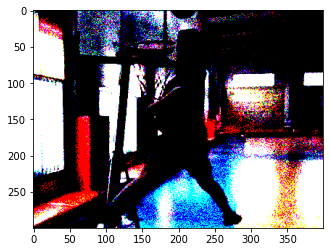

In [106]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import datetime


# GRADED FUNCTION: compute_content_cost
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """

    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()                # 用 a_G 和 a_C 的区别?

    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G,[n_H * n_W, n_C])

    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4*n_H*n_W*n_C)
    ### END CODE HERE ###

    return J_content


# GRADED FUNCTION: gram_matrix
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A, A ,transpose_a=False, transpose_b=True)       # 矩阵相乘,后面的flag表示是否对对应矩阵进行转置操作
    ### END CODE HERE ###

    return GA


# GRADED FUNCTION: compute_layer_style_cost
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images to have them of shape (n_H*n_W, n_C) (≈2 lines)
    a_S = tf.reshape(a_S, [n_W*n_H, n_C])
    a_G = tf.reshape(a_G, [n_W*n_H, n_C])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    # GS = gram_matrix(a_S)
    # GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4*tf.to_float(tf.square(n_C*n_H*n_W)))

    ### END CODE HERE ###

    return J_style_layer


def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name]
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out

        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style


# GRADED FUNCTION: total_cost
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###

    return J


def model_nn(sess, input_image, num_iterations=200):
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###

    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###

    for i in range(num_iterations):

        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)

        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)

    # save last generated image
    save_image('output/generated_image.jpg', generated_image)

    return generated_image

def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1,300,400,3)).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

if __name__ == '__main__':
    starttime = datetime.datetime.now()

    ###############################################
    # Reset the graph
    tf.reset_default_graph()

    # Start interactive session
    sess = tf.InteractiveSession()
    content_image = scipy.misc.imread("images/test.jpg")
    content_image = reshape_and_normalize_image(content_image)
    
    style_image = scipy.misc.imread("images/VG.jpg")
    style_image = reshape_and_normalize_image(style_image)
    
    generated_image = generate_noise_image(content_image)
    plt.imshow(generated_image[0])

    model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
    
    STYLE_LAYERS = [                                     # style_layers 的作用
        ('conv1_1', 0.2),
        ('conv2_1', 0.2),
        ('conv3_1', 0.2),
        ('conv4_1', 0.2),
        ('conv5_1', 0.2)]
    
    # Assign the content image to be the input of the VGG model
    sess.run(model["input"].assign(content_image))
    
    # Select the output tensor
    out = model['conv4_2']
    
    # Set a_C to be the hidden layer activation from the layer we have selected 
    a_C = sess.run(out)
    
    # Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2']
    # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
    # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
    
    a_G = out
    
    # Compute the content cost
    J_content = compute_content_cost(a_C, a_G)
    
    
    # Assign the input of the model to be the "style" image
    print(style_image.shape)
    sess.run(model['input'].assign(style_image))
    
    # Compute the style cost
    J_style = compute_style_cost(model, STYLE_LAYERS)
    
    J = total_cost(J_content = J_content, J_style = J_style)
    
    # define optimizer
    optimizer = tf.train.AdamOptimizer(2.0)
    
    # define train_step
    train_step= optimizer.minimize(J)
    
    model_nn(sess, generated_image)
    #################################################
    
    endtime = datetime.datetime.now()
    print("the running time :" + str((endtime - starttime).seconds))
    print("END!")